In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import LMC
import archinfo
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

from KDEpy import FFTKDE

pi = np.pi

MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

REARTH = 6371e3
RNEPTUNE = 24622e3

In [2]:
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/exoarchive_ipac_confirmed_200507.csv'  #reading in file

raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[77]
VALUES = raw_data[78:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return arr

In [3]:
'''
What I need:
- star name 
- planet radius --> comes from planet mass
- star mass
- planet mass
- planet semi-major axis --> comes from planet's period
- star radius
'''

d = {}
d['starname'] = get_key('pl_hostname')  #get star name

d['radius'] = get_key('pl_radj')  #get radius of planets (Jupiter radius)
d['star_radius'] = get_key('st_rad')  #get radius of star (solar radii)

d['mp'] = get_key('pl_bmassj')  #get mass of planets (in Jupiter masses)
                                #mass can be expressed as Msin(i), where i is the inclination

d['ms'] = get_key('st_mass')  #get mass of stars (in solar masses)

d['a'] = get_key('pl_orbsmax')  #get planet's semi-major axis (in AU)

d['p'] = get_key('pl_orbper')  #get planet's period (in days)

d['disc_method'] = get_key('pl_discmethod')  #get planet's deteciton method (Transit, RV, etc.)

In [4]:
def is_number(num):
    try:
        float(num)
        return True
    except ValueError:
        return False
    
def mass_radius(mp): 
    '''
    mp - float
    
    Uses the mass-radius relation given in Chen and Kipping (2016).  This method takes mass and 
    outputs radius.  mp is given in Earth masses, and rp is returned in Jupiter radii.  
    '''
    
    if type(mp) != list:
        if mp <= 2:                                          
            rp = 10**0.00346*mp**0.2790*REARTH/RJUPITER
        elif mp*MEARTH/MJUPITER <= 0.41:
            rp = 10**-0.0925*mp**0.589*REARTH/RJUPITER
        elif mp*MEARTH/MSUN <= 0.08:
            rp = 10**1.25*mp**-0.044*REARTH/RJUPITER
        else:
            rp = 10**-2.85*mp**0.881*REARTH/RJUPITER
    else:
        rp = []
        mp = np.array(mp).astype(float)
        for m in mp:
            if m <= 2:                                          
                rp.append(10**0.00346*m**0.2790*REARTH/RJUPITER)
            elif m*MEARTH/MJUPITER <= 0.41:
                rp.append(10**-0.0925*m**0.589*REARTH/RJUPITER)
            elif m*MEARTH/MSUN <= 0.08:
                rp.append(10**1.25*m**-0.044*REARTH/RJUPITER)
            else:
                rp.append(10**-2.85*m**0.881*REARTH/RJUPITER)
        rp = np.array(rp).astype(float)
    return rp 


def radius_mass(rp):
    '''
    If rp is an individual number, function will return an individual number for mp.
    If rp is a list, function will return a list for mp.
    
    Takes a radius measurement and outputs its corresponding mass using the mass-radius relation in Chen and Kipping
    (2016).  This is kind of like the inverse of mass_radius above.
    '''
    if type(rp) != list:
        rp = float(rp)
        if rp < 1.23:
            mp = 10**((np.log10(rp)-0.00346)/0.2790)
        elif rp <= 11.1:
            mp = 10**((np.log10(rp)+0.0925)/0.589)
        elif rp >= 14.3:
            mp = 10**((np.log10(rp)+2.85)/0.881)
        else:
            mp = 0
    else:
        rp = np.array(rp).astype(float)
        mp = []
        for r in rp:
            if r < 1.23:
                mp.append(10**((np.log10(r)-0.00346)/0.2790))
            elif r <= 11.1:
                mp.append(10**((np.log10(r)+0.0925)/0.589))
            elif r >= 14.3:
                mp.append(10**((np.log10(r)+2.85)/0.881))
            else:
                mp.append(0)
        mp = np.array(mp).astype(float)
    return mp

stars = []   #convert to arrays
rp = []
rs = []
mp = []
ms = []
a = []
p = []
switches = []

for i in range(len(d['a'])):
    if is_number(d['ms'][i]) and is_number(d['a'][i]) and is_number(d['star_radius'][i]) \
    and is_number(d['p'][i]):
        if is_number(d['radius'][i]) and is_number(d['mp'][i]):
            if d['disc_method'][i] == 'Radial Velocity' or d['disc_method'][i] == 'Transit':
                switches.append('Both')
                rp.append(d['radius'][i])
                mp.append(d['mp'][i])
                stars.append(d['starname'][i])
                ms.append(d['ms'][i])
                a.append(d['a'][i])
                rs.append(d['star_radius'][i])
                p.append(d['p'][i])
        elif is_number(d['radius'][i]) and is_number(d['mp'][i]) == False and d['disc_method'][i] == 'Transit':
            switches.append('Transit')
            rp.append(d['radius'][i])
            mp.append('')
            stars.append(d['starname'][i])
            ms.append(d['ms'][i])
            a.append(d['a'][i])
            rs.append(d['star_radius'][i])
            p.append(d['p'][i])
        elif is_number(d['radius'][i]) == False and is_number(d['mp'][i]) and d['disc_method'][i] == 'Radial Velocity':
            switches.append('Radial Velocity')
            mp.append(d['mp'][i])  
            rp.append('')
            stars.append(d['starname'][i])
            ms.append(d['ms'][i])
            a.append(d['a'][i])
            rs.append(d['star_radius'][i])
            p.append(d['p'][i])
            
for i in range(len(rp)):
    if rp[i] == '':
        rp[i] = mass_radius(float(mp[i])*MJUPITER/MEARTH)
    if mp[i] == '':
        mp[i] = radius_mass(float(rp[i])*RJUPITER/REARTH)*MEARTH/MJUPITER


In [5]:
def convert_to_float(arr):
    final = []
    for a in arr:
        final.append(float(a))
    return final

rp = convert_to_float(rp)
rs = convert_to_float(rs)
mp = convert_to_float(mp)
ms = convert_to_float(ms)
a = convert_to_float(a)
p = convert_to_float(p)

In [6]:
uniquestars = []
for s in stars:
    if s not in uniquestars:              #one instance of each star in uniquestars
        uniquestars.append(s)

In [7]:
def split_array(arr, s = stars, u = uniquestars):
    final_array = []
    corresponding_stars = []
    for i in range(len(u)):
        mini_array = []
        for j in range(len(s)):
            if s[j] == u[i]:
                mini_array.append(arr[j])
        if len(mini_array) >= 3:
            final_array.append(mini_array)
            corresponding_stars.append(u[i])
    return final_array, corresponding_stars

def get_rprs(rp, rs):
    rprs = []
    for i in range(len(rp)):
        rprs.append(rp[i]*RJUPITER/(rs[i]*RSUN))
    return rprs

def get_mu(mp, ms):
    Mstar = ms[0]
    mu = 0
    for i in range(len(mp)):
        mu = mu + mp[i]*MJUPITER/(Mstar*MSUN)
    return mu

def error_rprs(r):
    r_final = []
    for i in range(len(r)):
        if r[i] < 1:
            r_final.append(r[i])
    return r_final

rprs = get_rprs(rp, rs)

In [8]:
def convert_masses(arr):
    arr_new = []
    for a in arr:
        arr_new.append(a*MEARTH/MJUPITER)
    return arr_new

def P_to_a(periods, star_mass):
    a = []
    for p in periods:
        p = p*24*60*60
        a.append((p**2*BIGG*star_mass/(4*pi**2))**(1/3)/1.496e11)
    return a

rs_final, stars_that_matter = split_array(rs)
rp_final, stars_that_matter = split_array(rp)
rprs_final, stars_that_matter = split_array(rprs)
mp_final, stars_that_matter = split_array(mp)
ms_final, stars_that_matter = split_array(ms)
a_final, stars_that_matter = split_array(a)
p_final, stars_that_matter = split_array(p)
switches, stars_that_matter = split_array(switches)

i = 0
while i < len(switches):
    signal = 'Yes'
    for j in range(len(switches[i])):
        if switches[i][j] != 'Both':
            signal = 'No'
    if signal == 'No':
        del rs_final[i]
        del rp_final[i]
        del rprs_final[i]
        del mp_final[i]
        del ms_final[i]
        del a_final[i]
        del p_final[i]
        del switches[i]
        del stars_that_matter[i]
    else:
        i = i + 1

mu_final = []
for i in range(len(mp_final)):
    mu_final.append(get_mu(mp_final[i], ms_final[i]))
    
print('Number of systems: ' + str(len(stars_that_matter)))
for i in range(len(mp_final)):
    for j in range(len(mp_final[i])):
        print(str(mp_final[i][j]*MJUPITER/MEARTH) + " " + str(rp_final[i][j]*RJUPITER/REARTH) + " " + \
              str(p_final[i][j]) + " " + stars_that_matter[i])

Number of systems: 18
8.749487608841259 1.9093570867995604 3.5951 EPIC 249893012
14.670408573342263 3.5882745251922774 15.624 EPIC 249893012
10.179661754855994 3.8626074399623294 35.747 EPIC 249893012
4.9102645679839245 1.5472376393030918 1.2089819 GJ 9827
0.8390354989953113 1.21803814157903 3.6480957 GJ 9827
4.039447421299397 1.975196986344373 6.2014698 GJ 9827
11.266594105827194 3.2261550776958092 0.658524 K2-266
0.2892129939718687 0.6913189452205305 7.814 K2-266
8.898861352980576 2.8640356301993406 14.697 K2-266
14.298563295378433 2.6774892481557053 19.482 K2-266
9.680689886135298 2.5348361324752786 3.471745 K2-285
15.677886805090422 3.4565947261026526 7.138048 K2-285
6.499346952444741 2.425102966567258 10.45582 K2-285
10.700880776959142 1.9093570867995604 14.76289 K2-285
10.487943737441393 1.678917438392717 3.743208 KOI-94
15.573007367716007 4.2247268874587975 10.423648 KOI-94
106.15070328198259 11.02818317375608 22.342989 KOI-94
34.959812458137975 6.419390205619212 54.32031 KOI-94

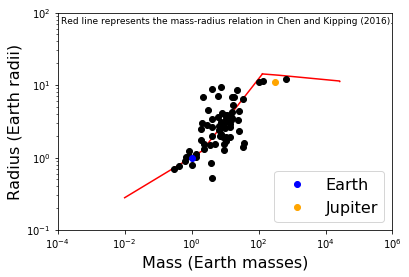

In [9]:
'''
Print masses and radii of each remaining planet to check if they are consistent.
'''
masses = np.array([item for sublist in mp_final for item in sublist])
radii = np.array([item for sublist in rp_final for item in sublist])

x = np.linspace(0.01, 2, 100).tolist()
y = mass_radius(x)
plt.plot(x, y*RJUPITER/REARTH, '-r')

x = np.linspace(2, 0.41*MJUPITER/MEARTH, 100).tolist()
y = mass_radius(x)
plt.plot(x, y*RJUPITER/REARTH, '-r')

x = np.linspace(0.41*MJUPITER/MEARTH, 0.08*MSUN/MEARTH, 100).tolist()
y = mass_radius(x)
plt.plot(x, y*RJUPITER/REARTH, '-r')

plt.plot(masses*MJUPITER/MEARTH, radii*RJUPITER/REARTH, 'o', color='black')
                                                                              #add in Earth and Jupiter for reference
plt.plot(1, 1, 'o', color='blue', label='Earth')                                                 #Earth
plt.plot(MJUPITER/MEARTH, RJUPITER/REARTH, 'o', color='orange', label='Jupiter')                 #Jupiter

plt.xlabel('Mass (Earth masses)', fontsize=16)
plt.xscale("log")
plt.xlim(10**-4, 10**6)
plt.ylabel('Radius (Earth radii)', fontsize=16)
plt.yscale("log")
plt.ylim(10**-1, 10**2)
plt.text(10**-3.9, 70, 'Red line represents the mass-radius relation in Chen and Kipping (2016).', fontsize=9)

plt.legend(loc='lower right', fontsize=16)

'''
There are a couple RV planets whose radii are already known.
'''

plt.show()

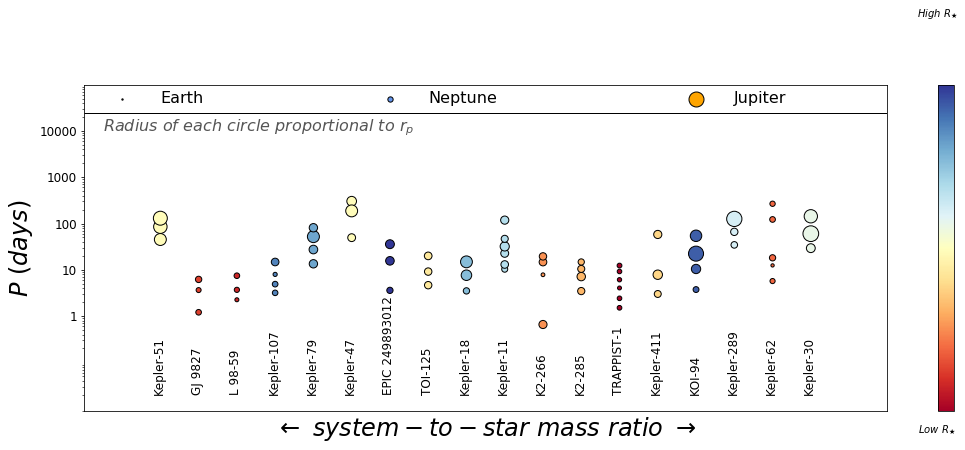

In [10]:
mu_rank = np.array(stats.rankdata(mu_final), dtype = 'int')
mu_pos = []
for i in range(len(mu_final)):
    for j in range(len(mp_final[i])):
        mu_pos.append(mu_rank[i])

cm = plt.cm.get_cmap('RdYlBu')

rs_rank = np.array(stats.rankdata([item for sublist in rs_final for item in sublist])-1, dtype = 'int')

plt.figure(figsize = (18, 6))
plt.tight_layout()

plt.scatter(mu_pos, [item for sublist in p_final for item in sublist], c = rs_rank, cmap = cm, s = 225*np.array([item for sublist in rp_final for item in sublist]), edgecolors = 'black')
cbar = plt.colorbar()
plt.clim(min(rs_rank), max(rs_rank))
cbar.set_ticks([])
cbar.ax.text(1, -3, r"$Low\ R_{\bigstar}$", va = 'bottom', ha = 'center')
cbar.ax.text(1, 80, r"$High\ R_{\bigstar}$", va = 'top', ha = 'center')

for i in range(len(rp_final)):
    plt.text(mu_rank[i]-0.2, 0.02, stars_that_matter[i], rotation = 90, va = 'bottom', fontsize = 12)
        


plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

plt.ylim(0.009, 100000)



plt.hlines(25000, -1, 22, lw = 1)
plt.vlines(22, 25000, 90000, lw = 1)
plt.plot(0, 50000, 'o', markersize=15*REARTH/RJUPITER, color='lightgrey', mec='k', mew=1)
plt.text(1, 50000, 'Earth', va='center', fontsize=16)
plt.plot(7, 50000, 'o', markersize=15*RNEPTUNE/RJUPITER, color='cornflowerblue', mec='k', mew=1)
plt.text(8, 50000, 'Neptune', va='center', fontsize=16)
plt.plot(15, 50000, 'o', markersize=15*RJUPITER/RJUPITER, color='orange', mec='k', mew=1)
plt.text(16, 50000, 'Jupiter', va='center', fontsize=16)





'''
The large planet on the right, Gilese 876b, is about 0.5% the mass of its star, so the radius here is going to be greater
than 1.  Also, I assume Gilese 876c is the planet that appears to be just behind Gilese 876b.
'''


plt.text(-0.5,20000, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p$', \
         fontsize=16, color='#555555', va='top')
 
plt.show()

In [11]:
N_final = []
for i in range(len(mp_final)):
    N_final.append(len(mp_final[i]))
    
# we already have mu_final

sv_p_final = p_final
sv_mp_final = mp_final 
for i in range(len(mp_final)):                                     #convert to Earth masses
    sv_p_final[i] = np.array(p_final[i])                           #sort each system by increasing period
    sv_mp_final[i] = (MJUPITER/MEARTH)*np.array(mp_final[i])       #that will play a role in the value of S
    order = np.argsort(sv_p_final[i])
    sv_p_final[i] = sv_p_final[i][order]
    sv_mp_final[i] = sv_mp_final[i][order]
p_final = sv_p_final
mp_final = sv_mp_final

Q_final = []
for i in range(len(mp_final)):
    Q_final.append(archinfo.Q(mp_final[i]))
    
M_final = []
for i in range(len(mp_final)):
    M_final.append(archinfo.M(p_final[i], mp_final[i]))
    
S_final = []
for i in range(len(mp_final)):
    S_final.append(archinfo.S(p_final[i], mp_final[i], ms_final[i][0]))
    
C_final = []
for i in range(len(p_final)):
    C_final.append(archinfo.C(p_final[i])[0])
    
N_final = np.array(N_final)
Q_final = np.array(Q_final)
M_final = np.array(M_final)
S_final = np.array(S_final)
C_final = np.array(C_final)
logmu_final = np.log10(np.array(mu_final))

log_mu_over_N = []
for i in range(len(mu_final)):
    log_mu_over_N.append(np.log10(mu_final[i]/N_final[i]))
log_mu_over_N = np.array(log_mu_over_N)